<a href="https://colab.research.google.com/github/JasmineZhangxyz/genderDebiasing/blob/main/Custom_Word2Vec_2020_debiasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Word2Vec Models

For Zhao et al.'s and Savani et al.'s debiasing methods, we created our own model and skip-gram traning loops below. 

Using cpu device
Generating Skip Grams...
...(0.0000min)
Training. Curr Time = 21:35:52 , Estimated Finish Time = 21:35:56
Epoch: 1, Training Loss: 78.76356244087219  (0.0007min)
Epoch: 2, Training Loss: 78.31131100654602  (0.0008min)
Epoch: 3, Training Loss: 78.03463006019592  (0.0008min)
Epoch: 4, Training Loss: 77.85876369476318  (0.0007min)
Epoch: 5, Training Loss: 77.7405686378479  (0.0008min)


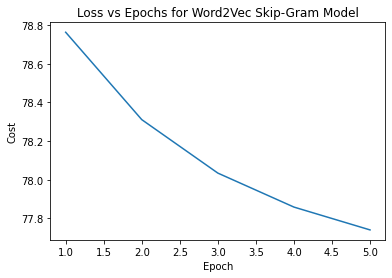

...(0.0068min)
TPM,TNM,FPM,FNM,TPF,TNF,FPF,FNF 0 27 0 0 0 27 0 9
0 / 4  sampled. Best objective so far:  -0.46714285714285714 for threshold:  0.464
TPM,TNM,FPM,FNM,TPF,TNF,FPF,FNF 0 27 0 0 0 27 0 9
1 / 4  sampled. Best objective so far:  -0.46714285714285714 for threshold:  0.464
TPM,TNM,FPM,FNM,TPF,TNF,FPF,FNF 0 27 0 0 0 27 0 9
2 / 4  sampled. Best objective so far:  -0.46714285714285714 for threshold:  0.464
TPM,TNM,FPM,FNM,TPF,TNF,FPF,FNF 0 27 0 0 0 27 0 9


In [ ]:
"""
Custom Word2Vec

We created our own model and skip-gram traning loops below.
"""

#imports
import torch
from torch import nn, optim, sigmoid
import tensorflow
from keras.preprocessing.sequence import skipgrams 
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import math
import copy
from sklearn.decomposition import PCA
from numpy.linalg import norm


#check which device pytorch will use, set default tensor type to cuda
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f'Using {device} device')
#torch.set_default_tensor_type('torch.cuda.FloatTensor') #to run on google colab


class skipgram(nn.Module):
    """
    defines the layers of the word2vec model
    
    Embedding Layer Target - target words to compare the context words (output embeddings)
    Embedding Layer Context - context words to compare to target words
    Linear - after the dot product of target and context layers, this linear layer transforms the output to 1 dim to compare with 1 = relevant pair, 0 - irrelevant pair labels 
    """
    
    def __init__(self, size_vocab, embedding_dim):
        super(skipgram, self).__init__()
        self.embeddings_target =  nn.Embedding(size_vocab+1, embedding_dim, max_norm=1).to(device) #what we care about
        self.embeddings_context = nn.Embedding(size_vocab+1, embedding_dim, max_norm=1).to(device) #used in loss calculation
        self.linear = nn.Linear(embedding_dim,1)
        

    def forward(self, target_tensor, context_tensor): #loss
        embedding_t = self.embeddings_target(target_tensor)
        embedding_c = self.embeddings_context(context_tensor)
        
        return torch.sigmoid(self.linear(torch.mul(embedding_t, embedding_c))).squeeze(1)

class Custom_Word2Vec:
    """
    defines the word2vec model
    
    hyperparameters: 
    - embedding_dim: embedding dimension (default 10)
    - LR: learning rate for optimizer (default 0.01)
    - window_size: window of context words to generate skip-gram pairs (default 10)
    - EPOCHS: number of iterations to run training (default 10)
    - min_freq: min frequency of word to be present in vocab for easier training (default 100)
    """
    
    def __init__(self, sentance_tokens, embedding_dim=10, LR=0.01, window_size=10, EPOCHS=10, min_freq=100, gender_pairs=[], pred_threshold=0.80, gendered_m=[],gendered_f=[], equalized_pairs=[],epsilon=0.05):
        #hyperparamters
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.lr = LR
        self.epochs = EPOCHS
        self.min_freq = min_freq

        
        #data, corpus
        self.sentance_tokens = sentance_tokens
        self.corpus_vocab = self.corpus_vocab()
        self.size_vocab = len(self.corpus_vocab)
        self.skip_grams =  self.create_target_context_pairs()
        
        #model, loss, optimizer
        self.model = skipgram(self.size_vocab, self.embedding_dim)
        self.loss_fcn = nn.BCELoss() # use binary cross entropy as the loss function
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr) #use stochiastic gradient descent

        #debiasing
        self.gendered_pairs = gender_pairs
        self.pred_threshold = pred_threshold
        self.gendered_m = gendered_m
        self.gendered_f = gendered_f
        self.equalized_pairs = equalized_pairs
        self.epsilon = epsilon
        

    def corpus_vocab(self):
        """
        define a dictionary where keys are words, and the values are the unique ids of the words
        """

        #count frequency of each word
        vocab_counts = {}
        for sentance in self.sentance_tokens:
            for word in sentance:
                vocab_counts[word] = vocab_counts.get(word, 0) + 1

        #create corpus by assigning unique ids
        i = 1
        corpus_vocab = {}
        for k, v in sorted(vocab_counts.items(), key=lambda item: item[1], reverse=True):
            if (v < self.min_freq): #break if frequency too low
                break;
            corpus_vocab[k] = i
            i+=1

        return corpus_vocab

    def create_target_context_pairs(self):
        """
        generate [(target, context), 1] pairs as positive samples - contextually relevant pair
        and [(target, random), 0] pairs as negative samples - contextually irrelevant pair
        """
            
        print("Generating Skip Grams...")
        tic = time.perf_counter()
        
        #get the word ids that exist in the corpus for all the sentances
        word_ids_datatset = []
        for sentance in self.sentance_tokens:
            word_ids =[]
            for word in sentance:
                if word in self.corpus_vocab:
                    word_ids.append(self.corpus_vocab[word])
            word_ids_datatset.append(word_ids)
        
        #generate skipgrams (pairs) for all sentances
        skip_grams = [skipgrams(word_ids, vocabulary_size=self.size_vocab, window_size=self.window_size) for word_ids in word_ids_datatset]
        
        toc = time.perf_counter()
        print(f"...({(toc - tic)/60:0.4f}min)")
        
        return skip_grams
    
    def embedding(self, word):
        idx = self.corpus_vocab[word]
        embedding = self.model.embeddings_target(torch.Tensor([idx]).long())
        return embedding.detach().cpu().numpy()[0]
    
    def train(self, plot=True):
        
        #get time estimate for training
        time_finish = datetime.now() + timedelta(seconds=(1/26)*len(self.skip_grams)*self.epochs)
        print("Training. Curr Time =", datetime.now().strftime("%H:%M:%S"), ", Estimated Finish Time =", time_finish.strftime("%H:%M:%S"))
        
        tic = time.perf_counter()
        losses_epochs = []

        #loop over epochs
        for epoch in range(self.epochs):
            tic_e = time.perf_counter()
            total_loss = 0
            
            #iterate through all target, context pairs
            for pairs, labels in self.skip_grams:
                
                # zero the gradients
                self.optimizer.zero_grad()

                # calculate loss 
                sentance_losses = []
                for i in range (len(pairs)): #pairs in a sentance
                    target_tensor = torch.Tensor([pairs[i][0]]).long() #target word
                    context_tensor =  torch.Tensor([pairs[i][1]]).long() #context word (true or random)
                    label = torch.Tensor([labels[i]]).float() # 1- relevant, 0 - irrelevent

                    output = self.model(target_tensor, context_tensor)
                    loss_pair = self.loss_fcn(output,label)
                    sentance_losses.append(loss_pair)


                #loss backward, optimizer step
                if sentance_losses:
                    loss = torch.sum(torch.stack(sentance_losses))
                    loss.backward()
                    total_loss+= loss.item()
                    self.optimizer.step()
                    
            toc_e = time.perf_counter()
            print(f'Epoch: {epoch+1}, Training Loss: {total_loss}  ({(toc_e - tic_e)/60:0.4f}min)')
            losses_epochs.append(total_loss)
        
        # plot loss over epochs
        if plot:
            epochs = [i+1 for i in range(self.epochs)]
            plt.plot(epochs,losses_epochs)
            plt.title('Loss vs Epochs for Word2Vec Skip-Gram Model')
            plt.xlabel('Epoch')
            plt.ylabel('Cost')
            plt.show()
        
        toc = time.perf_counter()
        print(f"...({(toc - tic)/60:0.4f}min)")

    # --------------------Find Gender Prediciton ---------------------
    # need to predict gender labels so cosine similarity of axis with a arbitrary threshold can be used

    def cos_sim(self,a,b):
        '''
        returns the cosine similarity between 2 word embeddings 
        '''
        return np.dot(a, b)/(norm(a)*norm(b))



    # ------------------- Random Pertubation ------------------- 
    # adapted from: https://github.com/abacusai/intraprocessing_debiasing?fbclid=IwAR3TiXq-3idbj1x4IFT4rBDpt5mHTdyYW82k7Ro6se06Etsls06LX0xEjVc
    
    #helpers
    def get_best_thresh(self, threshs, margin, bias):
        '''
        calculates best threshold and its corresponding objective function output 
        '''
        objectives = []
        for thresh in threshs:
            objectives.append(self.objective_function(self.epsilon - margin, thresh, bias))
        return threshs[np.argmax(objectives)], np.max(objectives)

    def compute_performance(self, thresh):
        '''
        Finds y_true (skip gram labels) and y_pred (model outputs with assigned 1 or 0 based on thresh), 
        and returns an accuracy score using balanced_accuracy_score()
        '''
        y_true = []
        y_pred = []

        for pairs, labels in self.skip_grams:
            for i in range (len(pairs)): #pairs in a sentance
                target_tensor = torch.Tensor([pairs[i][0]]).long() #target word
                context_tensor =  torch.Tensor([pairs[i][1]]).long() #context word (true or random)
                y_true.append(labels[i])

                #model output, 1 or 0 based on threshold
                output = self.model(target_tensor, context_tensor)
                output_np = output.detach().numpy()[0]
                if output_np > thresh:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
        
        return balanced_accuracy_score(y_true, y_pred)
    
    def objective_function(self, epsilon, thresh, bias):
      # bias = 0 #we do not have defined protected groups in this case
      performance = self.compute_performance(thresh)
      return - epsilon*abs(bias) - (1-epsilon)*(1-performance)


    def word_prediction(self,word):
      gender_pairs = self.gender_pairs
      thr = self.pred_threshold
      model = self.model
      male_pred = 0
      female_pred = 0
      for pair in gender_pairs:
        # 0 = female, 1 = male
        female_pred += self.cos_sim(self.embedding(pair[0]),self.embedding(word))
        male_pred += self.cos_sim(self.embedding(pair[1]),self.embedding(word))
      d = len(gender_pairs)
      gender_sim = [male_pred/d,female_pred/d]
      n = np.argmax(gender_sim)
      m = max(gender_sim)
      #male,female
      output = [0,0]
      if m > thr:
        output[n] = 1
        return output
      else:
        #predict gender neutral
        return output



    def get_bias(self):
      TPM = 0 # labeled as male & predicted as male
      TNM = 0 # labeled as non-male & predicted as non-male
      FPM = 0 # labeled as non-male & predicted as male
      FNM = 0 # labeled as male & predicted as male
      TPF = 0 # labeled as female & predicted as female
      TNF = 0 # labeled as non-female & predicted as non-female
      FPF = 0 # labeled as non-female & predicted as female
      FNF = 0 # labeled as female & predicted as non-female

      for word in self.corpus_vocab.keys():
        if word in self.gendered_m:
          label = self.word_prediction(word)
          if label[0] == 1: #predicted as male
            TPM += 1
          elif label[1] == 1: #predicted as non-male
            FNM += 1

        elif word in self.gendered_f:
          label = self.word_prediction(word)
          if label[1] == 1: #predicted as female
            TPF += 1
          elif label[1] == 0: #predicted as non-female
            FNF += 1
        else:
          label = self.word_prediction(word)
          if label == [0,0]: #gender neutral
            TNM += 1
            TNF += 1
          elif label[0] == 1:
            FPM += 1
          elif label[1] == 1:
            FPF += 1

      print("TPM,TNM,FPM,FNM,TPF,TNF,FPF,FNF",TPM,TNM,FPM,FNM,TPF,TNF,FPF,FNF)
      TPRM = TPM/(TPM+FNM+1)
      TPRF = TPF/(TPF+FNF+1)
      TNRM = TNM/(TNM+FPM+1)
      TNRF = TNF/(TNF+FPF+1)
      EOD = TPRM - TPRF
      # rho = 0.5 * (TPRM + TPRF + TNRM + TNRF)
      rho = 0
      if EOD < self.epsilon:
        rho = 0.5 * (TPRM + TPRF + TNRM + TNRF)
      return rho



    def labeling_gender(self):
      # alternative database if needed: https://github.com/ecmonsen/gendered_words/blob/master/gendered_words.json
      # current pairs come from 2016/data/equalize_pairs
      # This will serve as the gender labels for the 2020 debiasing technique. Anything else will be classified as gender neutral
      equalized_pairs = self.equalized_pairs
      male = []
      female = []
      for pair in equalized_pairs:
        male.append(pair[0])
        female.append(pair[1])

      self.gendered_m = male
      self.gendered_f = female
      return None




    #main 
    def random_debiasing(self,num_trails, stddev, margin):
      '''
      Hyperparameters:
        - num_trials - number of iterations
        - stddev: 0.1
        - margin: 0.01
        - epsilon: 0.05
      '''
      #set self.gendered_m and self.gendered_f
      self.labeling_gender()

      rand_result = {'objective': -math.inf, 'model': self.model.state_dict(), 'thresh': -1}
      
      for iteration in range(num_trails):
          
          for param in self.model.parameters():
              param.data = param.data * (torch.randn_like(param) * stddev + 1)

          threshs = np.linspace(0, 1, 501)


          bias = self.get_bias()



          best_rand_thresh, best_obj = self.get_best_thresh(threshs, margin, bias)

          if best_obj > rand_result['objective']:
              rand_result = {'objective': best_obj, 'model': copy.deepcopy(self.model.state_dict()), 'thresh': best_rand_thresh}
        
          print(iteration,"/",num_trails," sampled. Best objective so far: ", rand_result["objective"], "for threshold: ", rand_result["thresh"])

      print('Updating Model with best objective function results.')
      self.model.load_state_dict(rand_result['model']) #load model which had the best objective function

        
        



embedding_dim=10
LR=0.01
window_size=2
EPOCHS=5
min_freq= 1
sen = [['he', 'was', 'cool'], ['she', 'loved', 'meat'], ['you', 'do', 'nothing'],['she','he'],['her','his'],['woman','man'],['Mary','John'],['herself','himself'],['daughter','son'],['mother','father'],['gal','guy'],['girl','boy'],['female','male'],["prostate_cancer", "ovarian_cancer"], ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"], ["brothers", "sisters"], ["businessman", "businesswoman"], ["chairman", "chairwoman"]]

word_2_vec = Custom_Word2Vec(sen, embedding_dim, LR, window_size, EPOCHS, min_freq)

word_2_vec.train()
# print ("embedding: ", word_2_vec.embedding('he'))

# word_2_vec.equalized_pairs = [["prostate_cancer", "ovarian_cancer"], ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"], ["brothers", "sisters"], ["businessman", "businesswoman"], ["chairman", "chairwoman"]]
word_2_vec.equalized_pairs = [["monastery", "convent"], ["spokesman", "spokeswoman"], ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"], ["councilman", "councilwoman"], ["grandpa", "grandma"], ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"], ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"], ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], ["brothers", "sisters"], ["businessman", "businesswoman"], ["chairman", "chairwoman"], ["colt", "filly"], ["congressman", "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"], ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"], ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], ["gentlemen", "ladies"], ["grandfather", "grandmother"], ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], ["his", "her"], ["king", "queen"], ["kings", "queens"], ["male", "female"], ["males", "females"], ["man", "woman"], ["men", "women"], ["nephew", "niece"], ["prince", "princess"], ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]
word_2_vec.gender_pairs = [['she','he'],['her','his'],['woman','man'],['Mary','John'],['herself','himself'],['daughter','son'],['mother','father'],['gal','guy'],['girl','boy'],['female','male']]
word_2_vec.pred_threshold=0.80
word_2_vec.epsilon=0.05


embedding_before = word_2_vec.embedding('he')

word_2_vec.random_debiasing(4, 0.1, 0.01)
embedding_after = word_2_vec.embedding('he')

print(embedding_before, "VS, ", embedding_after)

"""

How to Use:
- define a Custom_Word2Vec instance with the hyperparamters
- call the .train() function
- acess trained embeddings via .embedding()


Example:

word_2_vec = Custom_Word2Vec([['he', 'was', 'cool'], ['she', 'loved', 'meat'], ['you', 'do', 'nothing']], window_size=2, min_freq=1)
#word_2_vec.train()

embedding_before = word_2_vec.embedding('he')

word_2_vec.random_debiasing(10, 0.1, 0.01, 0.05)
embedding_after = word_2_vec.embedding('he')

print(embedding_before, "VS, ", embedding_after)
"""

NOTE TO FUTURE EMILY: train on gutenberg also try to speed up random perturbation cause it be slow. If things aren't working it is because the values: pred_threshold and epsilon should be altered. ATM almost everyhting is under pred_threshold, but this may be a different case with an embedding that was been trained properly